In [1]:
%matplotlib notebook

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from math import exp


class Scheme(ABC):

    @abstractmethod
    def solve(self, grid, initial_conditions, border_conditions):
        """Решение дифференциального уравнения"""

In [2]:

class SchemeDZ1(Scheme):

    def __init__(self, const):
        self.solution_ = None
        self.const_ = const
        self.c = None
        self.grid_ = None

    def calc_first_time_layer(self, i):
        # c = self.c
        u0 = self.solution_.get_u_n(0)
        dt = self.grid_.get_step_x()
        dx = self.grid_.get_step_t()
        return u0[i] - self.const_ * dt * (u0[i + 1] - u0[i - 1]) / (2 * dx) +\
            self.const_ * dt * dt / 2 * (u0[i - 1] - 2 * u0[i] + u0[i + 1]) / (dx * dx)

    def calc_next_time_layer(self, n, i):
        c = self.c
        un = self.solution_.get_u_n(n)
        unm1 = self.solution_.get_u_n(n - 1)
        return 2 * c * c / (1 + c) * un[i - 1] + 2 * (1 - c) * un[i] - (1 - c) / (1 + c) * unm1[i]

    def solve(self, grid, initial_conditions, border_conditions):
        self.solution_ = Solution(initial_conditions, grid)
        self.grid_ = grid
        self.c = self.const_ * grid.get_step_t() / grid.get_step_x()
        print(f'c * dt / dx = {self.c}')

        if border_conditions.get_type_of_boundary_condition() == 'periodic':
            border_conditions.set_left_bc(lambda t: self.solution_.get_u_ni(0, -1))

        solution_1 = []
        for i in range(1, grid.get_num_step_x() - 1):
            solution_1.append(self.calc_first_time_layer(i))

        if border_conditions.get_type_of_boundary_condition() == 'outflow':
            border_conditions.set_right_bc(lambda t: solution_1[-1])
        elif border_conditions.get_type_of_boundary_condition() == 'periodic':
            border_conditions.set_left_bc(lambda t: solution_1[-1])
            border_conditions.set_right_bc(lambda t: solution_1[-1])

        self.solution_.add_new_temporary_layer(solution_1)
        border_conditions.boundary_condition_handler(self.solution_)

        for n in range(1, grid.get_num_step_t() - 1):

            solution_np1 = []

            for i in range(1, grid.get_num_step_x() - 1):
                solution_np1.append(self.calc_next_time_layer(n, i))

            if border_conditions.get_type_of_boundary_condition() == 'outflow':
                border_conditions.set_right_bc(lambda t: self.calc_next_time_layer(n, grid.get_num_step_x() - 1))
            elif border_conditions.get_type_of_boundary_condition() == 'periodic':
                border_conditions.set_left_bc(lambda t: self.calc_next_time_layer(n, grid.get_num_step_x() - 1))
                border_conditions.set_right_bc(lambda t: self.calc_next_time_layer(n, grid.get_num_step_x() - 1))

            self.solution_.add_new_temporary_layer(solution_np1)
            border_conditions.boundary_condition_handler(self.solution_)

        return self.solution_

In [3]:

class Solution:

    def __init__(self, initial_conditions, grid):
        self.grid_ = grid
        self.solution_ = [list(map(initial_conditions, grid.get_x_list()))]

    def add_new_temporary_layer(self, new_temporary_layer):
        self.solution_.append(list(new_temporary_layer))

    def __getitem__(self, item):
        return list([self.grid_.get_t_index(item), self.grid_.get_x_list(), self.solution_[item]])

    def get_u_ni(self, n, i):
        return self.solution_[n][i]

    def get_u_n(self, n):
        return self.solution_[n]

    def get_last_time(self):
        return self.grid_.get_t_index(len(self.solution_) - 1)

    def get_u(self):
        return self.solution_

    def get_grid(self):
        return self.grid_


In [4]:
class DifferentialEquation:

    def __init__(self, scheme, initial_conditions, border_conditions, grid):
        self.scheme_ = scheme
        self.initial_conditions_ = initial_conditions
        self.border_conditions_ = border_conditions
        self.grid_ = grid
        self.solution_ = Solution(initial_conditions, grid)

    def set_border_conditions(self, border_conditions):
        self.border_conditions_ = border_conditions

    def get_grid(self):
        return self.grid_

    def get_scheme(self):
        return self.scheme_

    def get_initial_conditions(self):
        return self.initial_conditions_

    def get_border_conditions(self):
        return self.border_conditions_

    def get_solution(self):
        return self.solution_

    def set_grid(self, grid):
        self.grid_ = grid

    def solve_eq(self):
        if self.grid_ is not None:
            self.solution_ = self.scheme_.solve(self.grid_, self.initial_conditions_, self.border_conditions_)
        else:
            print("Не задана область расчета")


In [5]:
class BorderConditions:

    """
    periodic - периодичные граничные условия
    outflow - выток
    """

    def __init__(self, left_bc=lambda t: 0, right_bc=lambda t: 0, type_of_boundary_condition=None):
        self.left_bc_ = left_bc
        self.right_bc_ = right_bc
        self.type_of_boundary_condition_ = type_of_boundary_condition

    def set_left_bc(self, left_bc):
        self.left_bc_ = left_bc

    def set_right_bc(self, right_bc):
        self.right_bc_ = right_bc

    def get_left_bc(self, t):
        return self.left_bc_(t)

    def get_right_bc(self, t):
        return self.right_bc_(t)

    def boundary_condition_handler(self, solution):
        solution.get_u_n(-1).insert(0, self.left_bc_(solution.get_last_time()))
        solution.get_u_n(-1).append(self.right_bc_(solution.get_last_time()))

    def get_type_of_boundary_condition(self):
        return self.type_of_boundary_condition_

In [6]:
class Grid:

    def __init__(self, x0=0, xn=1, t0=0, tn=1, step_x=0.01, step_t=0.01):
        self.x0_ = x0
        self.xn_ = xn
        self.t0_ = t0
        self.tn_ = tn
        self.step_x_ = step_x
        self.step_t_ = step_t
        self.num_step_x_ = round((self.xn_ - self.x0_) / self.step_x_)
        self.num_step_t_ = round((self.tn_ - self.t0_) / self.step_t_)
        self.x_list_ = []
        self.t_list_ = []
        self.generate_mesh()

    def get_x_lim(self):
        return [self.x0_, self.xn_]

    def get_t_lim(self):
        return [self.t0_, self.tn_]

    def generate_mesh(self):
        self.x_list_ = np.linspace(self.x0_, self.xn_, self.num_step_x_)
        self.t_list_ = np.linspace(self.t0_, self.tn_, self.num_step_t_)

    def get_x_list(self):
        return self.x_list_

    def get_t_list(self):
        return self.t_list_

    def get_num_step_x(self):
        return self.num_step_x_

    def get_num_step_t(self):
        return self.num_step_t_

    def get_t_index(self, index):
        return self.t_list_[index]

    def get_x_index(self, index):
        return self.x_list_[index]

    def get_step_t(self):
        return self.step_t_

    def get_step_x(self):
        return self.step_x_

In [7]:
class Visualizer:

    @staticmethod
    def x_t_diagram(diff_eq):
        solution = diff_eq.get_solution()
        ls = sum(solution.get_u(), [])
        grid = solution.get_grid()
        extent = [*grid.get_x_lim(), *grid.get_t_lim()]
        fig, ax = plt.subplots()
        image = ax.imshow(solution.get_u(), cmap=cm.coolwarm, origin='lower', extent=extent, vmin=min(ls), vmax=max(ls),
                          aspect="auto")
        cbar = fig.colorbar(image, ax=ax, fraction=.1)
        cbar.set_label(r'$U$, значение функции')

        ax.set_xlabel(r'$x$, координата')
        ax.set_ylabel(r'$t$, время')

        plt.title(Visualizer.get_ps_test(diff_eq))

        plt.show()

    @staticmethod
    def get_ps_test(diff_eq):

        ps_text = ''
        if diff_eq.get_border_conditions().get_type_of_boundary_condition() == 'periodic':
            ps_text = 'c периодическими граничными условиями'
        elif diff_eq.get_border_conditions().get_type_of_boundary_condition() == 'outflow':
            ps_text = 'c граничными условиями типа выток'
        return f"Решение {ps_text}"

    @staticmethod
    def plot_solution(diff_eq, temporary_layers=None, num_plot=3):

        solution = diff_eq.get_solution()

        if type(temporary_layers) is int:
            temporary_layers = [temporary_layers]

        if temporary_layers is None:
            num_step_t = diff_eq.get_solution().get_grid().get_num_step_t()
            temporary_layers = range(0, num_step_t, int(num_step_t / num_plot))

        fig, ax = plt.subplots()
        for t in temporary_layers:
            result = solution[t]
            u = result[1:]
            ax.plot(*u, label=rf'$t = {result[0]:.2f}$')

        ax.legend(loc=2)
        ax.set_xlabel(r'$x$, координата')
        ax.set_ylabel(r'$U$, значение функции')
        plt.title(Visualizer.get_ps_test(diff_eq))
        plt.show()

    @staticmethod
    def plot_solution_surface(diff_eq):

        solution = diff_eq.get_solution()
        ls = sum(solution.get_u(), [])

        z = np.asarray(ls)
        x_surf, t_surf = np.meshgrid(solution.get_grid().get_x_list(), solution.get_grid().get_t_list())
        z_surf = z.reshape(x_surf.shape)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x_surf, t_surf, z_surf, cmap=cm.coolwarm)
        ax.set_xlabel(r'$x$, координата')
        ax.set_ylabel(r'$t$, время')
        ax.set_zlabel(r'$U$, значение функции')

        plt.title(Visualizer.get_ps_test(diff_eq))

        plt.show()

c * dt / dx = 0.5


<IPython.core.display.Javascript object>


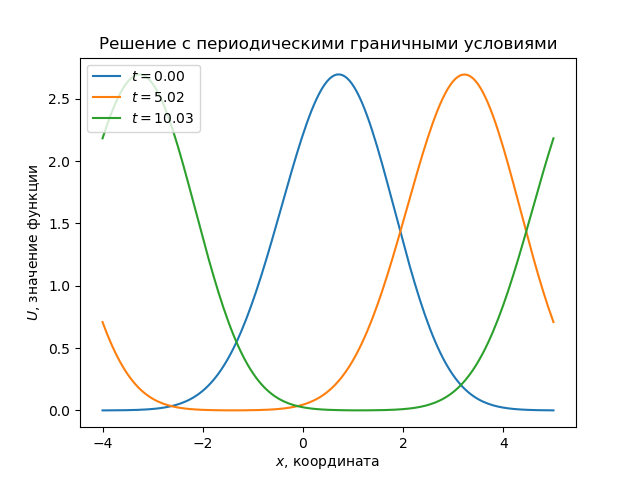

<IPython.core.display.Javascript object>


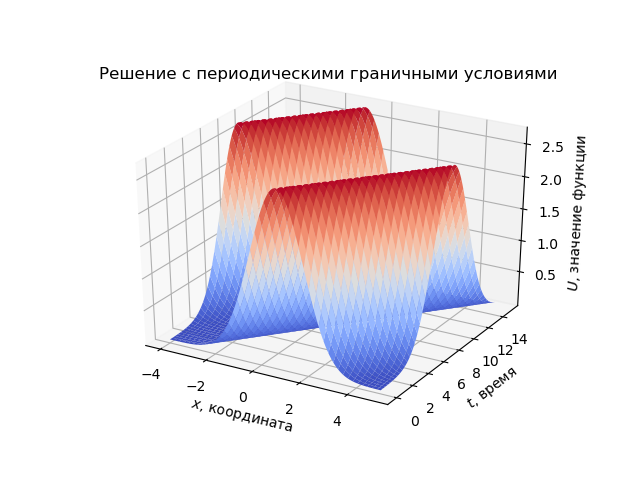

<IPython.core.display.Javascript object>


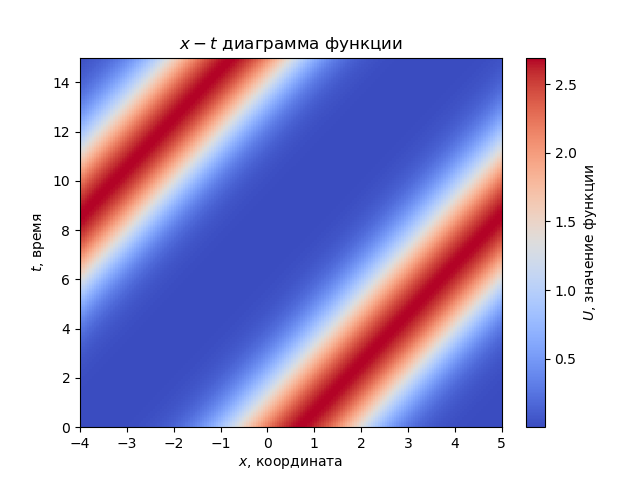

In [8]:
def initial_conditions(x):
    """
    U = exp(- x^2 / 2) + 2 * exp(- (x - 1) ^ 2 / 2)
    """
    u1 = 1
    u2 = 2
    return u1 * exp(- x ** 2 / 2) + u2 * exp(- (x - 1) ** 2 / 2)


##############

step = 0.05
c = 0.5  # константа С в условии задачи
x0 = -4
xn = 5
t0 = 0
tn = 15

###############

scheme = SchemeDZ1(c)
border_conditions_periodic = BorderConditions(type_of_boundary_condition='periodic')  # periodic, outflow

grid = Grid(x0=x0, xn=xn, t0=t0, tn=tn, step_x=step, step_t=step)

diff_eq = DifferentialEquation(scheme=scheme,
                               initial_conditions=initial_conditions,
                               border_conditions=border_conditions_periodic,
                               grid=grid)

diff_eq.solve_eq()

Visualizer.plot_solution(diff_eq)  # temporary_layers=[0, 10, 70, 80, 90, 99], num_plot=3
Visualizer.plot_solution_surface(diff_eq)
Visualizer.x_t_diagram(diff_eq)

In [ ]:
border_conditions_outflow = BorderConditions(type_of_boundary_condition='outflow')  # periodic, outflow
diff_eq.set_border_conditions(border_conditions_outflow)
diff_eq.solve_eq()

Visualizer.plot_solution(diff_eq)  # temporary_layers=[0, 10, 70, 80, 90, 99], num_plot=3
Visualizer.plot_solution_surface(diff_eq)
Visualizer.x_t_diagram(diff_eq)
